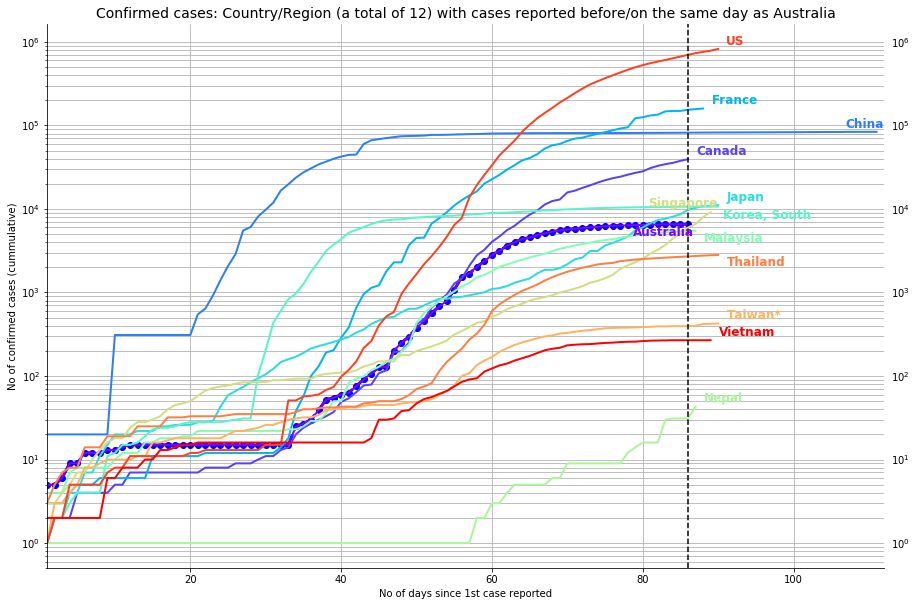

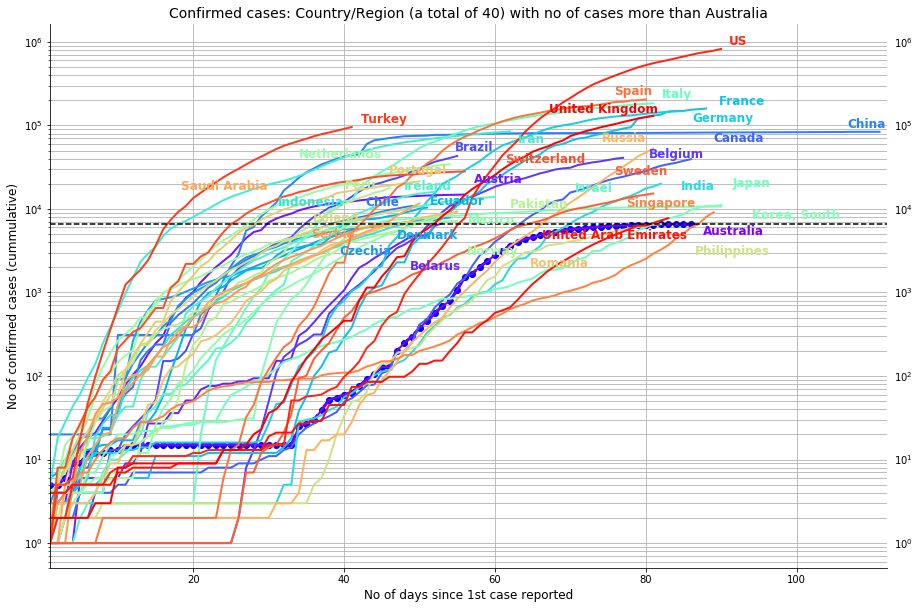

In [1]:
# All datasets are sourced from https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
from adjustText import adjust_text 
import itertools
import re
%matplotlib inline

# ************************** Confirmed cases  *******************************
url_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/\
csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
df_confirmed = pd.read_csv(url_confirmed, index_col="Country/Region")
df_confirmed.drop(['Lat', 'Long'], axis=1, inplace=True)
df_confirmed.head(10)
#df_confirmed.to_csv("C:/Users/das_g/Desktop/Gitua/COVID-19/time_series_2019-ncov-confirmed.csv")

# Data for Australian states 
Aust_confirmed = df_confirmed.loc["Australia"]
for i in range(len(Aust_confirmed)):  
      Aust_confirmed.index.values[i]= "Australia_"+ Aust_confirmed.iloc[i]['Province/State']
del Aust_confirmed["Province/State"]   

# Country grouping on original dataframe        
gr_confirmed = df_confirmed.groupby("Country/Region").sum()

# # Now adding Australian dataframe (this is to keep entry for Australia's total as well as state data)
gr_confirmed = pd.concat([gr_confirmed, Aust_confirmed])

# Adding data for China (1-Jan to 20-Jan from a China CDC publication)
lab=[]
for i in range(1,22):
    lab.append("1/" + str(i) + "/20")
    gr_confirmed.insert(i-1,lab[i-1],0)
gr_confirmed.loc["China"][0:10] = 20
gr_confirmed.loc["China"][10:21] = 310

# Remove Diamond princess
gr_confirmed = gr_confirmed.drop("Diamond Princess")

#Dates are converted into no of days since 1/1/20 so that 1/1/20 corresponds to day 1
dates = gr_confirmed.keys()
FMT = '%m/%d/%y'
days = dates.map(lambda x: (datetime.strptime(x, FMT) - datetime.strptime("1/1/20", FMT)).days) 
gr_confirmed.columns = days
x = gr_confirmed.ne(0).idxmax(axis=1) # x gives position of first non-zero value in each row
x_aust = gr_confirmed.loc["Australia"].ne(0).idxmax(axis=1)

# Subset of countries having cases reported earlier than Australia (i.e cases reported before 26Jan) 
gr_confirmed_sub = pd.DataFrame(columns= days)
for i in range(len(gr_confirmed.index)):
    if (x[i] <= x_aust) and (gr_confirmed.iloc[i].max() != 0) and\
        not(re.search('Australia_', gr_confirmed.index[i])):
       gr_confirmed_sub = gr_confirmed_sub.append(gr_confirmed.loc[gr_confirmed.index[i]]) 
   
x_sub = gr_confirmed_sub.ne(0).idxmax(axis=1) # x_sub gives position of first non-zero value in each row
for i in range(gr_confirmed_sub.shape[0]):
    gr_confirmed_sub.iloc[i] = gr_confirmed_sub.iloc[i].shift(periods=-x_sub[i]) # data starts from day when a first case is reported
gr_confirmed_sub.columns = dates

# ******** Subset of countries having no. of cases more than Australia **********
max_aust = gr_confirmed.loc["Australia"].max()
gr_confirmed_sub1 = pd.DataFrame(columns= days)
for i in range(len(gr_confirmed.index)):
    if gr_confirmed.iloc[i].max() >= max_aust:
       gr_confirmed_sub1 = gr_confirmed_sub1.append(gr_confirmed.loc[gr_confirmed.index[i]]) 

x_sub1 = gr_confirmed_sub1.ne(0).idxmax(axis=1) # x_sub1 gives position of first non-zero value in each row
for i in range(gr_confirmed_sub1.shape[0]):
    gr_confirmed_sub1.iloc[i] = gr_confirmed_sub1.iloc[i].shift(periods=-x_sub1[i]) # data starts from day when a first case is reported
gr_confirmed_sub1.columns = dates

for i in range(gr_confirmed.shape[0]):
    gr_confirmed.iloc[i] = gr_confirmed.iloc[i].shift(periods=-x[i]) # all data shift to one starting point 
gr_confirmed.columns = dates

# # # ---------------------------Visualising time series data ----------------------
# Visualising time series data for sub dataframe - cases reported earlier or on the same date as in Australia

no_plots = len(gr_confirmed_sub.index)
colors = cm.rainbow(np.linspace(0, 1, no_plots ))
plt.figure(figsize=(15,10))
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')

plt.title("Confirmed cases: Country/Region (a total of %i) with cases \
reported before/on the same day as Australia"%(no_plots-1), fontsize=14)
plt.xlabel("No of days since 1st case reported")
plt.ylabel("No of confirmed cases (cummulative)")
xpos = []
ypos = []
for i, color in enumerate(colors, start=0):
    if ( gr_confirmed_sub.iloc[i].tail(1).isnull().bool() == True):
       idx = pd.isnull(gr_confirmed_sub.iloc[i]).nonzero()[0]
       xpos.append(idx[0]) 
       ypos.append(gr_confirmed_sub.iloc[i][idx[0]-1]) 
    else:   
       xpos.append(len(gr_confirmed_sub.iloc[i]))
       ypos.append(gr_confirmed_sub.iloc[i][len(gr_confirmed_sub.iloc[i])-1])
    if gr_confirmed_sub.index[i] == "Australia":
       plt.plot(days, gr_confirmed_sub.iloc[i], "--bo", linewidth=3) 
    plt.plot(days, gr_confirmed_sub.iloc[i], "-", color=color, linewidth=2)
plt.yscale("log") # put this before the texts position else may throw error as ypos can exceed the limit
texts = [plt.text(xpos[i], ypos[i], gr_confirmed_sub.index[i], color=colors[i], fontsize=12, alpha=1,fontweight='bold') for i in range(len(gr_confirmed_sub.index))]
adjust_text(texts)
gr_confirmed_sub.columns = days
plt.axvline(gr_confirmed_sub.loc["Australia"].notna()[::-1].idxmax(), color='black', linestyle='--')
#plt.legend(loc="upper left")
plt.tick_params(labelright=True)
plt.grid(which="both")
plt.xlim(1, len(days))
#plt.savefig('C:/Users/das_g/Desktop/Gitua/COVID-19/Plot_Aust_confirmed_sub.jpg')
plt.show()

# Visualising time series data for sub dataframe - no of cases more than Australia
no_plots = len(gr_confirmed_sub1.index)
colors = cm.rainbow(np.linspace(0, 1, no_plots ))

plt.figure(figsize=(15,10))
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')

plt.title("Confirmed cases: Country/Region (a total of %i) with no of cases more than Australia"%(no_plots-1), fontsize=14, )
plt.xlabel("No of days since 1st case reported", fontsize=12)
plt.ylabel("No of confirmed cases (cummulative)", fontsize=12)

xpos = []
ypos = []
for i, color in enumerate(colors, start=0):
    if ( gr_confirmed_sub1.iloc[i].tail(1).isnull().bool() == True):
       idx = pd.isnull(gr_confirmed_sub1.iloc[i]).nonzero()[0]
       xpos.append(idx[0]) 
       ypos.append(gr_confirmed_sub1.iloc[i][idx[0]-1]) 
    else:   
       xpos.append(len(gr_confirmed_sub1.iloc[i]))
       ypos.append(gr_confirmed_sub1.iloc[i][len(gr_confirmed_sub1.iloc[i])-1])
    if gr_confirmed_sub1.index[i] == "Australia":
       plt.plot(days, gr_confirmed_sub1.iloc[i], "--bo", linewidth=3) 
    plt.plot(days, gr_confirmed_sub1.iloc[i], "-", color=color, linewidth=2)
plt.yscale("log") # put this before the texts position else may throw error as ypos can exceed the limit
texts = [plt.text(xpos[i], ypos[i], gr_confirmed_sub1.index[i], color=colors[i], fontsize=12,\
                  alpha=1,fontweight='bold') for i in range(no_plots)]
adjust_text(texts)
plt.axhline(gr_confirmed_sub.loc["Australia"].max(), color ='black', linestyle='--')
#plt.legend(loc="lower right")
plt.yscale("log")
plt.tick_params(labelright=True)
plt.grid(which="both")
plt.xlim(1,len(days))
#plt.savefig('C:/Users/das_g/Desktop/Gitua/COVID-19/Plot_Aust_confirmed_sub1.jpg')
plt.show()

# Writing the dataframes into a csv file
#gr_confirmed.to_csv("C:/Users/das_g/Desktop/Gitua/COVID-19/confirmed_gr.csv")


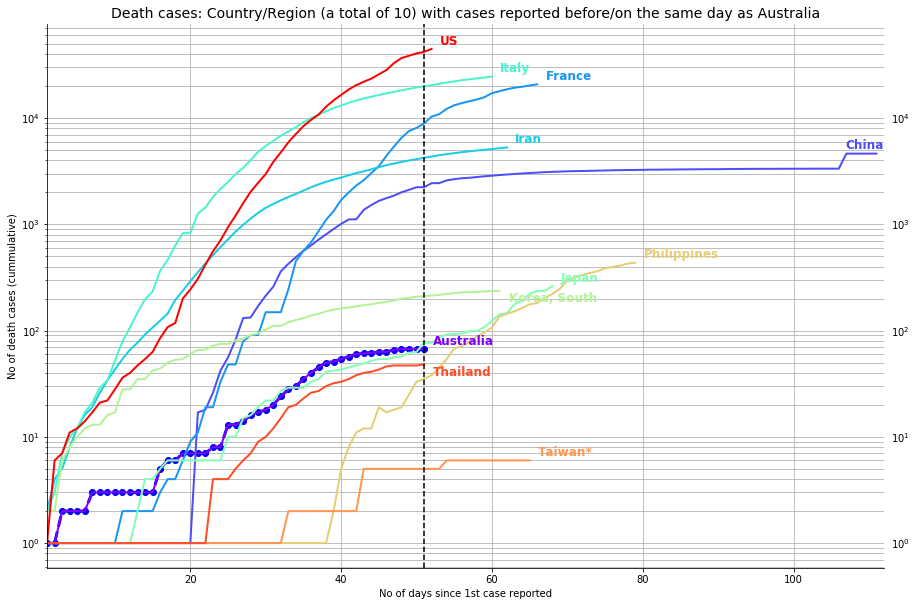

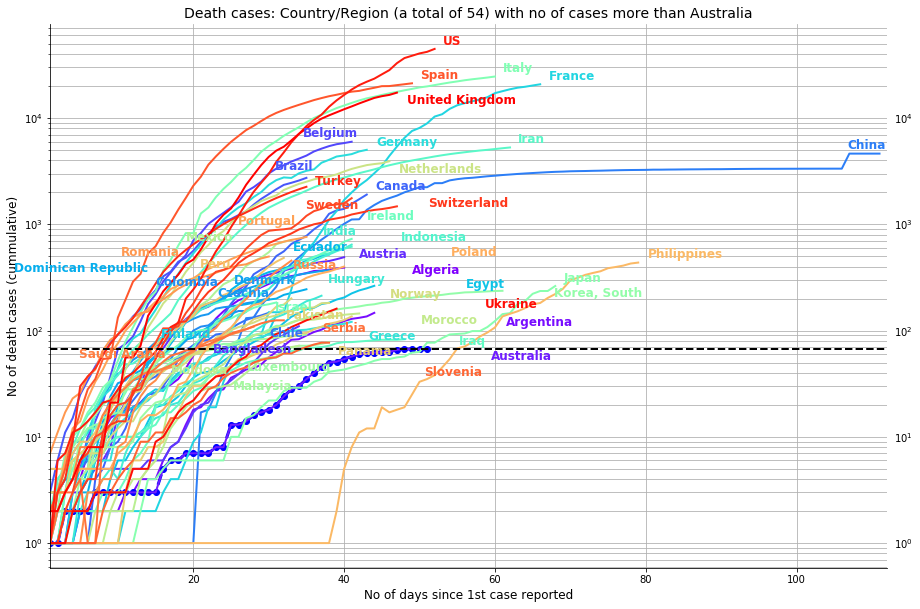

In [2]:
# ************************** Death cases  *******************************
url_death = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/\
csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
df_death = pd.read_csv(url_death, index_col="Country/Region")
df_death.drop(['Lat', 'Long'], axis=1, inplace=True)
df_death.head(10)

#df_death.to_csv("C:/Users/das_g/Desktop/Gitua/COVID-19/time_series_2019-ncov-death.csv")

# Australia states data
Aust_death = df_death.loc["Australia"]
for i in range(len(Aust_death)):  
      Aust_death.index.values[i]= "Australia_"+ Aust_death.iloc[i]['Province/State']
del Aust_death["Province/State"]   

# Country grouping on original dataframe        
gr_death = df_death.groupby("Country/Region").sum()

# # Now adding Australian dataframe
gr_death = pd.concat([gr_death, Aust_death])

# Adding data for China (1-Jan to 20-Jan) 
lab=[]
for i in range(1,22):
    lab.append("1/" + str(i) + "/20")
    gr_death.insert(i-1,lab[i-1],0)
gr_death.loc["China"][0:10] = 1
gr_death.loc["China"][10:21] = 1

# Remove Diamond princess
gr_death = gr_death.drop("Diamond Princess")

#Dates are converted into no of days since 1/22/20 so that 1/22/20 corresponds to day 1
dates = gr_death.keys()
FMT = '%m/%d/%y'
days = dates.map(lambda x: (datetime.strptime(x, FMT) - datetime.strptime("1/1/20", FMT)).days) 
gr_death.columns = days
x = gr_death.ne(0).idxmax(axis=1) # x gives position of first non-zero value in each row
x_aust = gr_death.loc["Australia"].ne(0).idxmax(axis=1)

# Subset of countries having cases reported earlier than Australia (i.e cases reporeted before 22Jan) 
gr_death_sub = pd.DataFrame(columns= days)
for i in range(len(gr_death.index)):
    if (x[i] <= x_aust) and (gr_death.iloc[i].max() != 0) and\
        not(re.search('Australia_', gr_death.index[i])):
       gr_death_sub = gr_death_sub.append(gr_death.loc[gr_death.index[i]]) 
   
x_sub = gr_death_sub.ne(0).idxmax(axis=1) # x_sub gives position of first non-zero value in each row
for i in range(gr_death_sub.shape[0]):
    gr_death_sub.iloc[i] = gr_death_sub.iloc[i].shift(periods=-x_sub[i]) # data starts from day when a first case is reported
gr_death_sub.columns = dates

# ******** Subset of countries having cases more than Australia **********
max_aust = gr_death.loc["Australia"].max()
gr_death_sub1 = pd.DataFrame(columns= days)
for i in range(len(gr_death.index)):
    if gr_death.iloc[i].max() >= max_aust:
       gr_death_sub1 = gr_death_sub1.append(gr_death.loc[gr_death.index[i]]) 

x_sub1 = gr_death_sub1.ne(0).idxmax(axis=1) # x_sub gives position of first non-zero value in each row
for i in range(gr_death_sub1.shape[0]):
    gr_death_sub1.iloc[i] = gr_death_sub1.iloc[i].shift(periods=-x_sub1[i]) # data starts from day when a first case is reported
gr_death_sub1.columns = dates

for i in range(gr_death.shape[0]):
    gr_death.iloc[i] = gr_death.iloc[i].shift(periods=-x[i]) # data starts from day when a first case is reported
gr_death.columns = dates


# # # ---------------------------Visualising time series data ----------------------
# Visualising time series data for sub dataframe -death cases reported earlier or on the same date as in Australia

no_plots = len(gr_death_sub.index)
colors = cm.rainbow(np.linspace(0, 1, no_plots ))
plt.figure(figsize=(15,10))
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')

plt.title("Death cases: Country/Region (a total of %i) with cases \
reported before/on the same day as Australia"%(no_plots-1), fontsize=14)
plt.xlabel("No of days since 1st case reported")
plt.ylabel("No of death cases (cummulative)")
xpos = []
ypos = []
for i, color in enumerate(colors, start=0):
    if ( gr_death_sub.iloc[i].tail(1).isnull().bool() == True):
       idx = pd.isnull(gr_death_sub.iloc[i]).nonzero()[0]
       xpos.append(idx[0]) 
       ypos.append(gr_death_sub.iloc[i][idx[0]-1]) 
    else:   
       xpos.append(len(gr_death_sub.iloc[i]))
       ypos.append(gr_death_sub.iloc[i][len(gr_death_sub.iloc[i])-1])
    if gr_death_sub.index[i] == "Australia":
       plt.plot(days, gr_death_sub.iloc[i], "--bo", linewidth=3) 
    plt.plot(days, gr_death_sub.iloc[i], "-", color=color, linewidth=2)
plt.yscale("log") # put this before the texts position else may throw error as ypos can exceed the limit
texts = [plt.text(xpos[i], ypos[i], gr_death_sub.index[i], color=colors[i], fontsize=12, alpha=1,fontweight='bold') for i in range(len(gr_death_sub.index))]
adjust_text(texts)
gr_death_sub.columns=days
plt.axvline(gr_death_sub.loc["Australia"].notna()[::-1].idxmax(), color ='black', linestyle='--')
#plt.legend(loc="upper left")
plt.tick_params(labelright=True)
plt.grid(which="both")
plt.xlim(1, len(days))
#plt.savefig('C:/Users/das_g/Desktop/Gitua/COVID-19/Plot_Aust_death_sub.jpg')
plt.show()

# Visualising time series data for sub dataframe - no of cases more than Australia
no_plots = len(gr_death_sub1.index)
colors = cm.rainbow(np.linspace(0, 1, no_plots ))

plt.figure(figsize=(15,10))
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')

plt.title("Death cases: Country/Region (a total of %i) with no of cases more than Australia"%(no_plots-1), fontsize=14, )
plt.xlabel("No of days since 1st case reported", fontsize=12)
plt.ylabel("No of death cases (cummulative)", fontsize=12)

xpos = []
ypos = []
for i, color in enumerate(colors, start=0):
    if ( gr_death_sub1.iloc[i].tail(1).isnull().bool() == True):
       idx = pd.isnull(gr_death_sub1.iloc[i]).nonzero()[0]
       xpos.append(idx[0]) 
       ypos.append(gr_death_sub1.iloc[i][idx[0]-1]) 
    else:   
       xpos.append(len(gr_death_sub1.iloc[i]))
       ypos.append(gr_death_sub1.iloc[i][len(gr_death_sub1.iloc[i])-1])
    if gr_death_sub1.index[i] == "Australia":
       plt.plot(days, gr_death_sub1.iloc[i], "--bo", linewidth=3) 
    plt.plot(days, gr_death_sub1.iloc[i], "-", color=color, linewidth=2)
plt.yscale("log") # put this before the texts position else may throw error as ypos can exceed the limit
texts = [plt.text(xpos[i], ypos[i], gr_death_sub1.index[i], color=colors[i], fontsize=12,\
                  alpha=1,fontweight='bold') for i in range(no_plots)]
adjust_text(texts)
plt.axhline(gr_death_sub.loc["Australia"].max(), color ='black', linestyle='--', linewidth=2)
#plt.legend(loc="lower right")
plt.yscale("log")
plt.tick_params(labelright=True)
plt.grid(which="both")
plt.xlim(1,len(days))
#plt.savefig('C:/Users/das_g/Desktop/Gitua/COVID-19/Plot_Aust_death_sub1.jpg')
plt.show()

# Writing the dataframes into a csv file
#gr_death.to_csv("C:/Users/das_g/Desktop/Gitua/COVID-19/death_gr.csv")


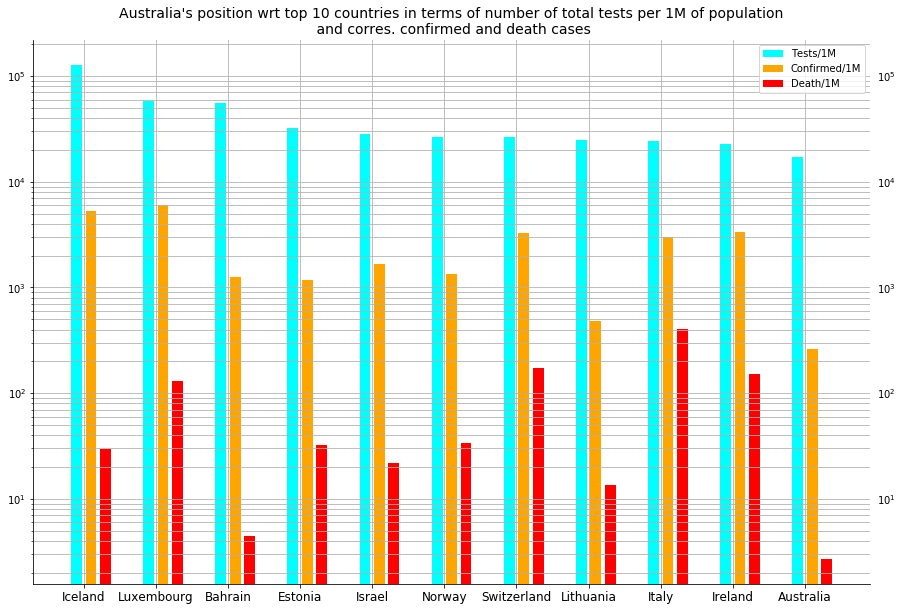

In [3]:
#  ************** Plotting top 10 countries in the world wrt tests/1M, and corres. confirmed/1M and death/1M
url_test= 'https://github.com/owid/covid-19-data/raw/master/public/data/testing/covid-testing.xlsx'
test_df = pd.read_excel(url_test, index_col="Entity")
test_df= (test_df.groupby("Entity").max()[["Cumulative total per thousand"]]) * 1000 #data converted to per M

# Sourced from www.dta.humdata.org
url_pop = 'https://sdmx.data.unicef.org/ws/public/sdmxapi/rest/data/UNICEF,DM,1.0/.DM_POP_TOT...?format=csv'
pop_df = pd.read_csv(url_pop, index_col="Geographic Area")
pop_df = pop_df["OBS_VALUE"] / 1000 # gives population in Million

# the sorting (descending order) is done w.r.t no of test cases. max() is used as a few countries have mulitiple entries
x = {}
for i in range(len(test_df.index)):
    x[test_df.index[i]]= test_df.iloc[i].max()

top_10 = {}
for w in sorted(x, key=x.get, reverse=True):
    top_10[w]= x[w]
# Get the top most 10 countries having max no. of tests
top_10 = dict(itertools.islice(top_10.items(), 10))

country_labels = [k for k,v in top_10.items()]
y_test_1M = [v for k,v in top_10.items()]
country_labels = [(country_labels[i].split('-', 1)[0]).rstrip() for i in range(len(country_labels))]

y_death = [gr_death.loc[country_labels[i]].max() for i in range(len(country_labels))] 
y_confirmed = [gr_confirmed.loc[country_labels[i]].max() for i in range(len(country_labels))] 

# Adding Australia
country_labels.append("Australia")
y_test_1M.append(test_df.loc["Australia - units unclear"])
y_confirmed.append(gr_confirmed.loc["Australia"].max())
y_death.append(gr_death.loc["Australia"].max())

y_confirmed = [y_confirmed[i] / (pop_df.loc[country_labels[i]]) for i in range(len(y_confirmed))]
y_death = [y_death[i] / (pop_df.loc[country_labels[i]]) for i in range(len(y_death))]

plt.figure(figsize=(15,10))
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
ind = np.arange(len(country_labels))
width = 0.2
plt.bar(ind, y_test_1M, color='cyan', label='Tests/1M', width=0.15)
plt.bar(ind+width, y_confirmed, color='orange', label="Confirmed/1M", width=0.15)
plt.bar(ind+2*width, y_death, color='red', label="Death/1M", width=0.15)
plt.title("Australia's position wrt top 10 countries in terms of number of total tests per 1M of population\n and corres. confirmed and death cases", fontsize=14)
plt.rc('ytick', labelsize=12)
plt.yscale("log")
plt.xticks(ind+width/2, country_labels, fontsize=12)
plt.legend(loc='best')
plt.grid(which="both")
plt.tick_params(labelright=True)
#plt.savefig('C:/Users/das_g/Desktop/Gitua/COVID-19/Plot_test_1M.jpg')
plt.show()

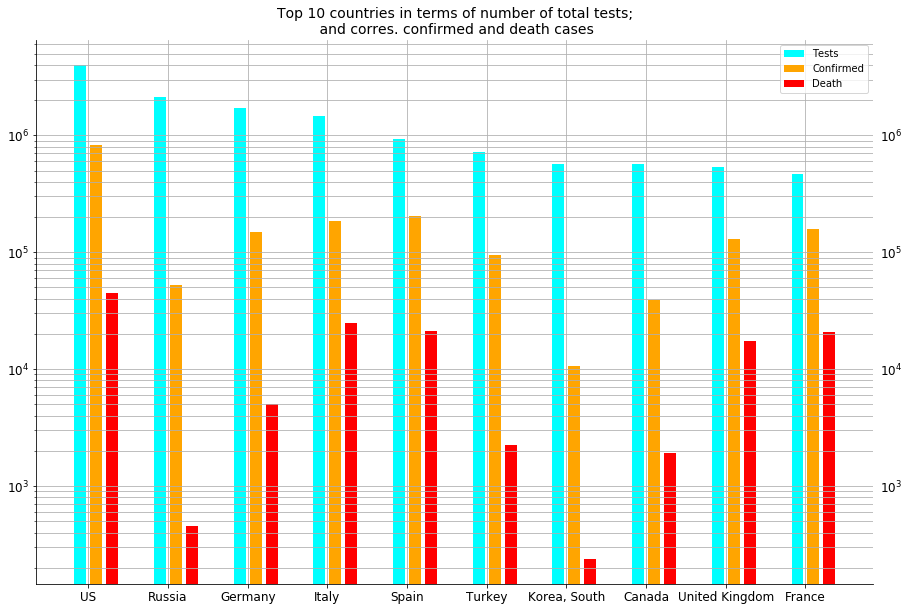

In [4]:
# ******** Top 10 countries in terms of total tests and their corres confirmed and death cases
url_test= 'https://github.com/owid/covid-19-data/raw/master/public/data/testing/covid-testing.xlsx'
test_df = pd.read_excel(url_test, index_col="Entity")
#test_df.to_csv("C:/Users/das_g/Desktop/Gitua/COVID-19/covid-testing.csv")
test_df= (test_df.groupby("Entity").max()[["Cumulative total"]])

x = {}
for i in range(len(test_df.index)):
    x[test_df.index[i]]= test_df.iloc[i].max()

top_10 = {}
for w in sorted(x, key=x.get, reverse=True):
   top_10[w]= x[w]
top_10 = dict(itertools.islice(top_10.items(), 10))

country_labels = [k for k,v in top_10.items()]
y_test = [v for k,v in top_10.items()]
country_labels = [(country_labels[i].split('-', 1)[0]).rstrip() for i in range(len(country_labels))]

country_labels_new = country_labels.copy()
for i in range(len(country_labels)):
    if country_labels[i] == "United States":
        country_labels[i] = "US"
    if country_labels[i] == "South Korea":
        country_labels[i] = "Korea, South"

y_death = [gr_death.loc[country_labels[i]].max() for i in range(len(country_labels))]
y_confirmed = [gr_confirmed.loc[country_labels[i]].max() for i in range(len(country_labels))]

plt.figure(figsize=(15,10))
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
ind = np.arange(len(country_labels))
width = 0.2
plt.bar(ind, y_test, color='cyan', label='Tests', width=0.15)
plt.bar(ind+width, y_confirmed, color='orange', label="Confirmed", width=0.15)
plt.bar(ind+2*width, y_death, color='red', label="Death", width=0.15)

plt.title("Top 10 countries in terms of number of total tests;\n and corres. confirmed and death cases", fontsize=14)
plt.rc('ytick', labelsize=12)
plt.yscale("log")
plt.xticks(ind+width/2, country_labels, fontsize=12)
plt.legend(loc='best')
plt.grid(which="both")
plt.tick_params(labelright=True)
#plt.savefig('C:/Users/das_g/Desktop/Gitua/COVID-19/Plot_test.jpg')
plt.show()